In [68]:
import asyncio

import datetime
import logging
import time
from typing import List, Tuple, Union
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import Result, text
from sqlalchemy.ext.asyncio import AsyncConnection, AsyncEngine, create_async_engine
from utils.dataframe import to_datetime_string
from config import settings

engine: AsyncEngine = create_async_engine(settings.DATABASE_URL, echo=False, future=True)

SAMSUNG_X1S = '6ea67f1e-fc9b-4c36-a808-21259b93f8f9' # minute
POLAR_MX = '77c91e84-838e-4699-ab6d-a85e4b9db69f'
SAMSUNG_BPA = '539c9710-90d2-407b-89fb-643a6637506a'

In [69]:
def cursor_to_df(cursor: Result) -> pd.DataFrame:
    df = pd.DataFrame([])
    values = cursor.fetchall()
    if values:
        df = pd.DataFrame(values)
        df.columns = cursor.keys()
    return df

async def _get_heart_rate_from_db(conn: AsyncConnection, eui: str) -> pd.DataFrame:
    sql = """
        SELECT ts, (data->>'pulse')::float as value FROM exam_guard.monitor_data WHERE monitor_id = :eui limit 540;
    """
    sql = """
        SELECT ts, (data -> 'payload' ->> 'hr')::float as value FROM exam_guard.monitor_data WHERE monitor_id = :eui limit 540;
    """
    cursor = await conn.execute(text(sql), {'eui': eui})
    return cursor_to_df(cursor)

async def _get_blood_preassure_from_db(conn: AsyncConnection, eui: str) -> pd.DataFrame:
    # /payload/bp_sys
    sql = """
        SELECT ts, (data -> 'payload' ->> 'bp_sys')::float as value FROM exam_guard.monitor_data WHERE monitor_id = :eui limit 540;
    """
    cursor = await conn.execute(text(sql), {'eui': eui})
    return cursor_to_df(cursor)

async def get_heart_rate_from_db() -> List[Tuple[int, float]]:
    async with engine.begin() as conn:
        df = await _get_heart_rate_from_db(conn, SAMSUNG_X1S)
        return list(zip(list(df['ts']), list(df['value'])))

async def get_blood_preassure_from_db() -> List[Tuple[int, float]]:
    async with engine.begin() as conn:
        df = await _get_blood_preassure_from_db(conn, SAMSUNG_BPA)
        return list(zip(list(df['ts']), list(df['value'])))
        

In [70]:
def interpolate(data, threshold):
    start_value = data[0][1]
    value_threshold = start_value + (start_value * threshold / 100)
    
    # Act
    df = pd.DataFrame(data, columns=['ts', 'value'])
    df = df.reindex(columns=['value', 'ts'])
    
    # Create datetime objects
    df['time'] = pd.to_datetime(df['ts'], unit='s', utc=False)
    del df['ts']
    
    # Set the datetime column as the index
    df.set_index('time', inplace=True)
    
    # Resample to seconds
    df = df.resample('s')

    # Fill gaps
    df = df.mean().interpolate()
    
    return df


def extract_outliers(
    dfs, value_threshold, duration
):
    value_threshold = start_value + (start_value * threshold / 100)
    threshold_data = []
    temp = []
    itimes = 0
    for j in range(len(dfs['value'])):
        value = dfs.iloc[j]['value']
        if value > value_threshold:
            temp.append(dfs.index[j])
            itimes += 1
        else:
            if itimes >= duration:
                threshold_data += temp
            itimes = 0
            temp = []
    for idx in threshold_data:
        dfs.loc[idx, 'is_anomaly'] = 'yes'


#################################### data_blood_preassure_from_db
threshold = 20
data_blood_preassure_from_db = await get_blood_preassure_from_db()
fixed_blood_preassure_from_db = interpolate(data_blood_preassure_from_db, threshold)
start_value = data_blood_preassure_from_db[0][1]
value_threshold = start_value + (start_value * threshold / 100)
extract_outliers(fixed_blood_preassure_from_db, value_threshold, 120)

#################################### data_heart_rate_from_db (x minute)
data_heart_rate_from_db = await get_heart_rate_from_db()

threshold = 30
fixed_heart_rate_from_db = interpolate(data_heart_rate_from_db, threshold)
# I need the same dimension as the first one
fixed_heart_rate_from_db = fixed_heart_rate_from_db.head(
    len(fixed_blood_preassure_from_db.index)
)
start_value = data_heart_rate_from_db[0][1]
value_threshold = start_value + (start_value * threshold / 100)
extract_outliers(fixed_heart_rate_from_db, value_threshold, 60)

# Filter the outliers by minute (data_heart_rate_from_db)
woop = [pd.to_datetime(item[0], unit='s', utc=False) for item in data_heart_rate_from_db]
for idx in fixed_heart_rate_from_db.index:
    if idx in woop and fixed_heart_rate_from_db.loc[idx, 'is_anomaly'] == 'yes':
        fixed_heart_rate_from_db.loc[idx, 'is_anomaly'] = 'yes'
    else:
        fixed_heart_rate_from_db.loc[idx, 'is_anomaly'] = 'no'
  

# Generate Plot

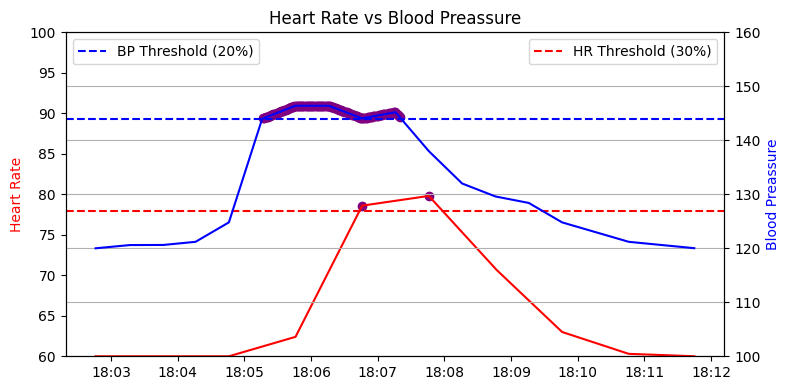

In [71]:

# Plot the heart rate data
plt.rcParams['figure.figsize'] = [8, 4]

fig = plt.figure()
# fig.set_figwidth(8)
ax1 = fig.add_subplot(111)
ax1.set_ylim(60, 100)
ax1.set_ylabel('Heart Rate', color='red')

threshold = 30
start_value = fixed_heart_rate_from_db.iloc[0]['value']
value_threshold = start_value + (start_value * threshold / 100)

ax1.axhline(y=value_threshold, color='red', linestyle='--', label='HR Threshold (30%)')  # Add threshold line
ax1.plot(fixed_heart_rate_from_db.index, fixed_heart_rate_from_db['value'], color='red')
ax1.legend(loc='upper right')

anomaly_df = fixed_heart_rate_from_db[fixed_heart_rate_from_db['is_anomaly'] == 'yes']
ax1.scatter(anomaly_df.index, anomaly_df['value'], color='purple')

# fixed_blood_preassure_from_db
color = 'blue'
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim(100, 160)
ax2.set_ylabel('Blood Preassure', color=color)

threshold = 20
start_value = fixed_blood_preassure_from_db.iloc[0]['value']
value_threshold = start_value + (start_value * threshold / 100)
ax2.axhline(y=value_threshold, color='blue', linestyle='--', label='BP Threshold (20%)')  # Add threshold line
ax2.plot(fixed_blood_preassure_from_db.index, fixed_blood_preassure_from_db['value'], color=color)  # Label the data line
ax2.legend(loc='upper left')


anomaly_df = fixed_blood_preassure_from_db[fixed_blood_preassure_from_db['is_anomaly'] == 'yes']
ax2.scatter(anomaly_df.index, anomaly_df['value'], color='purple')

# Format x-axis labels to show only time
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))

plt.xlabel('Time')
plt.title('Heart Rate vs Blood Preassure')
plt.grid(True)

plt.tight_layout()
plt.show()
